# Estimation of correlation between (centroid offset, position-angle offset) and the $\Sigma$ values

**Author(s):** Muhammad Jobair Hasan, Sulyman Hossain, Ahmad Al - Imtiaz, S M Rafee Adnan, Anowar J. Shajib

## Uncertainty propagation and the pearson correlation coeffient ($r$)

We assume that the parameters (`"center_x_light"`, `"center_x_mass"`, `"center_y_light"`, `"center_y_mass"` , `"phi_light"`, `"phi_mass"`) conform to Gaussian distributions of means equaling the corresponding medians and the standard deviations equaling the corresponding averages (of the upper and the lower) $1\sigma$ uncertainties. These uncertainties propagate (through our calculations using the Euclidean distance formula, or otherwise) to the values of light and mass centeroid offsets, and the position-angle offset, $\Delta\phi$. We then use normal distributions having the calculated (uncertainties propagated) means and uncertainties (standard deviations) to sample from and calculate the biweight midcorrelation ($r_{bicorr}$) between the centeroid (and the position-angle offsets) and the $\Sigma$ values. By sampling multiple times and calculating the biweight midcorrelations ($r_{bicorr}$) we get a population of $r_{bicorr}$ values and thus calculate its mean, $1\sigma$ upper and $1\sigma$ lower uncertainties.

The four $\Sigma$ values we consider are:
- $\Sigma_{10}$
- $\Sigma_{10, \rm flux\ selected}$
- $\Sigma_{20}$
- $\Sigma_{20, \rm flux\ selected}$

## Relevant formulae for centroid offset


For the case of $f = aA + bB$, where A and B are two random variables and a, b are constants, we have $$\sigma_{f} = \sqrt{a^{2}\sigma_{A}^2 + b^{2}\sigma_{B}^2 - 2ab\sigma_{AB}}$$
In the case of independent A, B ($\sigma_{AB}=0$) and $a=b=1$ we have $$\sigma_{f} = \sqrt{\sigma_{A}^2 + \sigma_{B}^2}$$
We also have for independent A, B ($\sigma_{AB}=0$) and $f = \sqrt{A^{2}+B^{2}}$,
$$\sigma_{f} \approx \sqrt{\left(\frac{A}{f}\right)^{2}\sigma_{A}^{2} + \left(\frac{B}{f}\right)^{2}\sigma_{B}^{2}}$$

## Relevant formulae for position-angle offset

For the case of $f = aA + bB$, where A and B are two random variables and a, b are constants, we have $$\sigma_{f} = \sqrt{a^{2}\sigma_{A}^2 + b^{2}\sigma_{B}^2 - 2ab\sigma_{AB}}$$
In the case of independent A, B ($\sigma_{AB}=0$) and $a=b=1$ we have $$\sigma_{f} = \sqrt{\sigma_{A}^2 + \sigma_{B}^2}$$

## Import the necessary libraries

In [80]:
from statistics import mean

import astropy.units as u
import coloripy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import paperfig as pf
import seaborn as sns
import yaml
from astropy.cosmology import FlatLambdaCDM
from astropy.stats import biweight_midcorrelation
from numpy.random import normal

# !pip install 'git+https://github.com/ajshajib/paperfig.git'
# !pip install 'git+https://github.com/ajshajib/coloripy.git'
#!pip install astropy

In [81]:
# Check version of coloripy and paperfig
print(cp.__version__)
print(pf.__version__)

0.0.0
0.1.0


## List of the model names

In [82]:
lens_names = [
    "DESIJ0132-1600",
    "DESIJ0136-0008",
    "DESIJ0201-2739",
    "DESIJ0215-2909",
    "DESIJ0618+5018",
    "DESIJ0923+1829",
    "DESIJ1018-0121",
    "DESIJ1101-0602",
    "DESIJ1205+4110",
    "DESIJ1501+5208",
    "DESIJ1537+1443",
    "DESIJ1554+0443",
    "DESIJ1624+0129",
    "DESIJ1709+3154",
    "DESIJ2158+0257",
]

## Estimate uncertainty in the Physical distance using Monte Carlo random sampling

In [83]:
# Define cosmological parameters
H0 = 70
Om0 = 0.3

# Define a function to estimate uncertainty in the Physical distance using
# Monte Carlo random sampling

np.random.seed(42)

def calculate_physical_distance_stats(
    z, z_uncertainty, angles_arcsec, angles_arcsec_uncertainty, num_samples=10000
):
    # Generate random samples of redshift and angular distance using normal distribution
    z_samples = np.random.normal(z, z_uncertainty, num_samples)
    angles_arcsec_samples = np.random.normal(
        angles_arcsec, angles_arcsec_uncertainty, num_samples
    )

    # Define a function to calculate physical distance
    # from redshift and angular distance

    def physical_distance(angles_arcsec, redshift):
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
        angular_diameter_distance = cosmo.angular_diameter_distance(redshift)

        angles_radian = np.radians(angles_arcsec / 3600)

        physical_distance = angular_diameter_distance * angles_radian
        physical_distance = physical_distance.to(u.kpc)

        return physical_distance.value

    # Calculate physical distances for each sampled redshift and angle
    physical_distances = physical_distance(angles_arcsec_samples, z_samples)

    # Calculate statistics in kiloparsec unit
    physical_distance_mean = np.mean(physical_distances)
    physical_distance_std = np.std(physical_distances)

    return physical_distance_mean, physical_distance_std

## Uncertainty propagation

In [84]:
# list for storing the Sigmas
Sigma_10a_dset = []
Sigma_10afs_dset = []
Sigma_10b_dset = []
Sigma_10bfs_dset = []
Sigma_10c_dset = []
Sigma_10cfs_dset = []
Sigma_10d_dset = []
Sigma_10dfs_dset = []

Sigma_20a_dset = []
Sigma_20afs_dset = []
Sigma_20b_dset = []
Sigma_20bfs_dset = []
Sigma_20c_dset = []
Sigma_20cfs_dset = []
Sigma_20d_dset = []
Sigma_20dfs_dset = []

data_points = []  # list dictionaries with the parameter values
center_diffs = []  # mean offsets between the light and mass centers
sigma_center_diffs = []  # uncertainty propagated standard deviation of the center off.
dphis = []  # mean offsets between the light and mass position angle
sigma_dphis = []  # uncertainty propagated standard deviation of the position angle off.

theta_E_m = []  # Einstein radius
theta_E_u = []
gamma_m = []  # gamma
gamma_u = []
gamma_shear_m = []  # shear
gamma_shear_u = []

phot_z = []  # photometric redshift


for i in range(len(lens_names)):
    lens_name = lens_names[i]

    output_path = f"../lens_systems/{lens_name}/{lens_name}_point_estimates.yml"

    try:
        with open(output_path, "r") as f:
            data = yaml.full_load(f)

    except AttributeError:
        print(f"Failed to load {lens_name}")
        continue

    list_params = [
        "center_x_light",
        "center_x_mass",
        "center_y_light",
        "center_y_mass",
        "phi_mass",
        "phi_light",
        "q_light",
        "gamma_shear",
        "theta_E",
        "gamma",
        "Sigma_10a",
        "Sigma_10a_flux_selected",
        "Sigma_10b",
        "Sigma_10b_flux_selected",
        "Sigma_10c",
        "Sigma_10c_flux_selected",
        "Sigma_10d",
        "Sigma_10d_flux_selected",
        "Sigma_20a",
        "Sigma_20a_flux_selected",
        "Sigma_20b",
        "Sigma_20b_flux_selected",
        "Sigma_20c",
        "Sigma_20c_flux_selected",
        "Sigma_20d",
        "Sigma_20d_flux_selected",
        "z_phot",
    ]
    # parameters filtered by list params
    outputs = {k: data.get(k) for k in list_params}

    data_points.append(outputs)

    Sigma_10a_dset.append(data.get("Sigma_10a"))
    Sigma_10afs_dset.append(data.get("Sigma_10a_flux_selected"))
    Sigma_10b_dset.append(data.get("Sigma_10b"))
    Sigma_10bfs_dset.append(data.get("Sigma_10b_flux_selected"))
    Sigma_10c_dset.append(data.get("Sigma_10c"))
    Sigma_10cfs_dset.append(data.get("Sigma_10c_flux_selected"))
    Sigma_10d_dset.append(data.get("Sigma_10d"))
    Sigma_10dfs_dset.append(data.get("Sigma_10d_flux_selected"))

    Sigma_20a_dset.append(data.get("Sigma_20a"))
    Sigma_20afs_dset.append(data.get("Sigma_20a_flux_selected"))
    Sigma_20b_dset.append(data.get("Sigma_20b"))
    Sigma_20bfs_dset.append(data.get("Sigma_20b_flux_selected"))
    Sigma_20c_dset.append(data.get("Sigma_20c"))
    Sigma_20cfs_dset.append(data.get("Sigma_20c_flux_selected"))
    Sigma_20d_dset.append(data.get("Sigma_20d"))
    Sigma_20dfs_dset.append(data.get("Sigma_20d_flux_selected"))

    x_diff = abs(
        data_points[i]["center_x_light"][0] - data_points[i]["center_x_mass"][0]
    )
    y_diff = abs(
        data_points[i]["center_y_light"][0] - data_points[i]["center_y_mass"][0]
    )

    center_diff = (x_diff**2 + y_diff**2) ** 0.5

    sigma_x_light = mean(
        [data_points[i]["center_x_light"][1], data_points[i]["center_x_light"][2]]
    )
    sigma_x_mass = mean(
        [data_points[i]["center_x_mass"][1], data_points[i]["center_x_mass"][2]]
    )
    sigma_y_light = mean(
        [data_points[i]["center_y_light"][1], data_points[i]["center_y_light"][2]]
    )
    sigma_y_mass = mean(
        [data_points[i]["center_y_mass"][1], data_points[i]["center_y_mass"][2]]
    )

    sigma_x_diff = (sigma_x_light**2 + sigma_x_mass**2) ** 0.5
    sigma_y_diff = (sigma_y_light**2 + sigma_y_mass**2) ** 0.5

    # Uncertainty in centroid offset in arcsecond
    sigma_center_diff = (
        ((x_diff / center_diff) ** 2) * sigma_x_diff**2
        + ((y_diff / center_diff) ** 2) * sigma_y_diff**2
    ) ** 0.5

    # Convert the angular distance to physical distance distribution
    # and estimate uncertainty (in kpc)

    z = data_points[i]["z_phot"][0]  # redshift
    z_uncertainty = data_points[i]["z_phot"][1]  # redshift's uncertainty
    center_diff, sigma_center_diff = calculate_physical_distance_stats(
        z, z_uncertainty, center_diff, sigma_center_diff
    )
    # print(center_diff, sigma_center_diff)

    center_diffs.append(center_diff)
    sigma_center_diffs.append(sigma_center_diff)

    dphi = abs(data_points[i]["phi_mass"][0] - data_points[i]["phi_light"][0])
    dphi = dphi * (180 / np.pi)  # radians-to-degrees conversion
    dphis.append(dphi)

    sigma_phi_mass = mean(
        [data_points[i]["phi_mass"][1], data_points[i]["phi_mass"][2]]
    )
    sigma_phi_light = mean(
        [data_points[i]["phi_light"][1], data_points[i]["phi_light"][2]]
    )

    sigma_dphi = (sigma_phi_mass**2 + sigma_phi_light**2) ** 0.5
    sigma_dphi = sigma_dphi * (180 / np.pi)  # radians-to-degrees conversion
    sigma_dphis.append(sigma_dphi)

    data_points[i]["dphi"] = [dphi, sigma_dphi, sigma_dphi]
    data_points[i]["center_diff"] = [center_diff, sigma_center_diff, sigma_center_diff]

    centroid_offset_np = [center_diff, sigma_center_diff, sigma_center_diff]
    centroid_offset_float = [x.item() for x in centroid_offset_np]

    # Extracting Einstein Radius (in arcsecond unit)
    theta_E_median = data_points[i]["theta_E"][0]
    theta_E_uncertainty = (
        data_points[i]["theta_E"][1] + data_points[i]["theta_E"][2]
    ) * 0.5

    # Extracting Gamma
    gamma_m.append(data_points[i]["gamma"][0])
    gamma_u.append((data_points[i]["gamma"][1] + data_points[i]["gamma"][2]) * 0.5)

    # Convert the angular distance to physical distance distribution
    # and estimate uncertainty (in kpc)

    z = data_points[i]["z_phot"][0]  # redshift
    phot_z.append(z)
    z_uncertainty = data_points[i]["z_phot"][1]  # redshift's uncertainty
    theta_E_mean, theta_E_std = calculate_physical_distance_stats(
        z, z_uncertainty, theta_E_median, theta_E_uncertainty
    )

    theta_E_m.append(theta_E_mean)
    theta_E_u.append(theta_E_std)

    data_points[i]["theta_E_kpc"] = [theta_E_mean, theta_E_std, theta_E_std]

    # Extracting Gamma Shear
    gamma_shear_m.append(data_points[i]["gamma_shear"][0])
    gamma_shear_u.append(
        (data_points[i]["gamma_shear"][1] + data_points[i]["gamma_shear"][2]) * 0.5
    )

    # Add the centroid and position-angle offsets to the yaml files
    # Load existing YAML content if the file exists
    existing_content = {}
    data_to_append = {
        "centroid_offset": centroid_offset_float,
        "position_angle_offset": [dphi, sigma_dphi, sigma_dphi],
    }

    try:
        with open(output_path, "r") as file:
            existing_content = yaml.safe_load(file)
    except FileNotFoundError:
        pass

    # Update the existing content with new variables
    existing_content.update(data_to_append)

    # Write the updated content back to the YAML file
    with open(output_path, "w") as file:
        yaml.dump(existing_content, file, default_flow_style=False)

In [85]:
# List system names with corresponding Einstein theta_E_m
theta_E_dict = dict(zip(lens_names, theta_E_m))
print(theta_E_dict)

# Min and Max values of theta_E_m
theta_E_min = min(theta_E_m)
theta_E_max = max(theta_E_m)
print(f"Min theta_E: {theta_E_min}, Max theta_E: {theta_E_max}")


{'DESIJ0132-1600': 7.017802155630228, 'DESIJ0136-0008': 13.115211238381397, 'DESIJ0201-2739': 6.337776494867027, 'DESIJ0215-2909': 8.277679067734887, 'DESIJ0618+5018': 13.983785375938815, 'DESIJ0923+1829': 9.938853571686085, 'DESIJ1018-0121': 15.637112549856496, 'DESIJ1101-0602': 12.30490019230281, 'DESIJ1205+4110': 19.105491090692695, 'DESIJ1501+5208': 19.06039272760479, 'DESIJ1537+1443': 10.764576331627586, 'DESIJ1554+0443': 9.9342651040427, 'DESIJ1624+0129': 19.990685376503492, 'DESIJ1709+3154': 14.596901810147896, 'DESIJ2158+0257': 14.030105363777812}
Min theta_E: 6.337776494867027, Max theta_E: 19.990685376503492


## Removing elements with high axis ratio q_light > 0.9 and gamma fixed

In [86]:
data_points_ex_q_l = data_points.copy()
dphis_ex_q_l = dphis.copy()
sigma_dphis_ex_q_l = sigma_dphis.copy()
Sigma_10a_dset_ex_q_l = Sigma_10a_dset.copy()
Sigma_10afs_dset_ex_q_l = Sigma_10afs_dset.copy()
Sigma_10b_dset_ex_q_l = Sigma_10b_dset.copy()
Sigma_10bfs_dset_ex_q_l = Sigma_10bfs_dset.copy()
Sigma_10c_dset_ex_q_l = Sigma_10c_dset.copy()
Sigma_10cfs_dset_ex_q_l = Sigma_10cfs_dset.copy()
Sigma_10d_dset_ex_q_l = Sigma_10d_dset.copy()
Sigma_10dfs_dset_ex_q_l = Sigma_10dfs_dset.copy()

Sigma_20a_dset_ex_q_l = Sigma_20a_dset.copy()
Sigma_20afs_dset_ex_q_l = Sigma_20afs_dset.copy()
Sigma_20b_dset_ex_q_l = Sigma_20b_dset.copy()
Sigma_20bfs_dset_ex_q_l = Sigma_20bfs_dset.copy()
Sigma_20c_dset_ex_q_l = Sigma_20c_dset.copy()
Sigma_20cfs_dset_ex_q_l = Sigma_20cfs_dset.copy()
Sigma_20d_dset_ex_q_l = Sigma_20d_dset.copy()
Sigma_20dfs_dset_ex_q_l = Sigma_20dfs_dset.copy()

# Indexes to remove (high axis ratio q_L> 0.9)
# DESIJ0136-0008, DESIJ0201-2739, DESIJ0923+1829,
# DESIJ1501+5208, DESIJ1554+0443, DESIJ2158+0257

indexes_high_ql = [1, 2, 5, 9, 11, 14]

# Removing elements by index in reverse order
for i in sorted(indexes_high_ql, reverse=True):
    del data_points_ex_q_l[i]
    del dphis_ex_q_l[i]
    del sigma_dphis_ex_q_l[i]
    del Sigma_10a_dset_ex_q_l[i]
    del Sigma_10afs_dset_ex_q_l[i]
    del Sigma_10b_dset_ex_q_l[i]
    del Sigma_10bfs_dset_ex_q_l[i]
    del Sigma_10c_dset_ex_q_l[i]
    del Sigma_10cfs_dset_ex_q_l[i]
    del Sigma_10d_dset_ex_q_l[i]
    del Sigma_10dfs_dset_ex_q_l[i]
    del Sigma_20a_dset_ex_q_l[i]
    del Sigma_20afs_dset_ex_q_l[i]
    del Sigma_20b_dset_ex_q_l[i]
    del Sigma_20bfs_dset_ex_q_l[i]
    del Sigma_20c_dset_ex_q_l[i]
    del Sigma_20cfs_dset_ex_q_l[i]
    del Sigma_20d_dset_ex_q_l[i]
    del Sigma_20dfs_dset_ex_q_l[i]

data_points_ex_gamma = data_points.copy()
gamma_m_ex = gamma_m.copy()
gamma_u_ex = gamma_u.copy()
Sigma_10a_dset_ex_gamma = Sigma_10a_dset.copy()

# Indexes to remove (gamma fixed)
# DESIJ0132-1600, DESIJ0618+5018, DESIJ1101-0602

indexes_gamma_fixed = [0, 4, 7]

# Removing elements by index in reverse order
for i in sorted(indexes_gamma_fixed, reverse=True):
    del data_points_ex_gamma[i]
    del gamma_m_ex[i]
    del gamma_u_ex[i]
    del Sigma_10a_dset_ex_gamma[i]

# Indexes to include for PA >14 degrees
# DESIJ0136-0008, DESIJ0618+5018, DESIJ0923+1829,
# DESIJ1501+5208, DESIJ0201-2739, DESIJ1537+1443

indexes_pa = [0, 3, 6, 7, 8, 11, 12, 13, 14] #[1, 4, 5, 9, 2, 10]

data_points_ex_pa = data_points.copy()
Sigma_10a_dset_ex_pa = Sigma_10a_dset.copy()
dphis_ex_pa = dphis.copy()
sigma_dphis_ex_pa = sigma_dphis.copy()
gamma_shear_m_ex_pa = gamma_shear_m.copy()
gamma_shear_u_ex_pa = gamma_shear_u.copy()

# Removing elements by index in reverse order

for i in sorted(indexes_pa, reverse=True):
    del data_points_ex_pa[i]
    del dphis_ex_pa[i]
    del sigma_dphis_ex_pa[i]
    del gamma_shear_m_ex_pa[i]
    del gamma_shear_u_ex_pa[i]
    del Sigma_10a_dset_ex_pa[i]


In [87]:
print("Mean redshifts:{0}".format(mean(phot_z)))  # mean redshift of the lenses

# The photometric redshifts of the lenses
for lens, z in zip(lens_names, phot_z):
    print(f"{lens}: {z}")

Mean redshifts:0.5811333333333334
DESIJ0132-1600: 0.359
DESIJ0136-0008: 0.34
DESIJ0201-2739: 0.747
DESIJ0215-2909: 0.941
DESIJ0618+5018: 0.519
DESIJ0923+1829: 0.682
DESIJ1018-0121: 0.4
DESIJ1101-0602: 0.327
DESIJ1205+4110: 0.621
DESIJ1501+5208: 0.752
DESIJ1537+1443: 0.653
DESIJ1554+0443: 0.591
DESIJ1624+0129: 0.786
DESIJ1709+3154: 0.72
DESIJ2158+0257: 0.279


## Sampling and biweight midcorrelation ($r_{bicorr}$) calculation

### Function definition

In [88]:
# Function for sampling and calculating the pearson correlation coefficients
# between two parameters


def sample2_and_calc_r(param1, param2, size, data):
    """
    Sample and calculate biweight_midcorrelation between param1 and the param2,
    and return a list of the form [r_median, r_lower, r_upper]

    :param param1: parameter for normal distribution sampling
    :param param2: parameter for normal distribution sampling
    :param size: population size of the pearson-r samples
    :param data: list of dictionaries containing the parameter values
    :return: list; [r_median, r_upper, r_lower]
    """

    samples_r = []

    for i in range(size):
        p1 = []
        p2 = []

        for j in range(len(data)):
            p1.append(
                normal(
                    data[j][param1][0],
                    (data[j][param1][1] + data[j][param1][2]) * 0.5,
                )
            )
            if isinstance(data[j][param2], list):
                p2.append(
                    normal(
                        data[j][param2][0],
                        (data[j][param2][1] + data[j][param2][2]) * 0.5,
                    )
                )
            else:
                p2.append(data[j][param2])

        samples_r.append(biweight_midcorrelation(np.array(p1), np.array(p2)))

    samples_r_arr = np.array(samples_r)
    r_median = np.median(samples_r_arr).item()
    r_lower = np.percentile(samples_r_arr, 16.0).item()
    r_upper = np.percentile(samples_r_arr, 84.0).item()

    return [r_median, r_upper, r_lower]

### Biweight midcorrelation ($r_{bicorr}$) calculation

In [89]:
size = 1000  # population size

# centoid offset cases
r_centroid_off_Sigma_10a = sample2_and_calc_r(
    "center_diff", "Sigma_10a", size, data_points
)
r_centroid_off_Sigma_10afs = sample2_and_calc_r(
    "center_diff", "Sigma_10a_flux_selected", size, data_points
)
r_centroid_off_Sigma_20a = sample2_and_calc_r(
    "center_diff", "Sigma_20a", size, data_points
)
r_centroid_off_Sigma_20afs = sample2_and_calc_r(
    "center_diff", "Sigma_20a_flux_selected", size, data_points
)

r_centroid_off_Sigma_10b = sample2_and_calc_r(
    "center_diff", "Sigma_10b", size, data_points
)
r_centroid_off_Sigma_10bfs = sample2_and_calc_r(
    "center_diff", "Sigma_10b_flux_selected", size, data_points
)
r_centroid_off_Sigma_20b = sample2_and_calc_r(
    "center_diff", "Sigma_20b", size, data_points
)
r_centroid_off_Sigma_20bfs = sample2_and_calc_r(
    "center_diff", "Sigma_20b_flux_selected", size, data_points
)

r_centroid_off_Sigma_10c = sample2_and_calc_r(
    "center_diff", "Sigma_10c", size, data_points
)
r_centroid_off_Sigma_10cfs = sample2_and_calc_r(
    "center_diff", "Sigma_10c_flux_selected", size, data_points
)
r_centroid_off_Sigma_20c = sample2_and_calc_r(
    "center_diff", "Sigma_20c", size, data_points
)
r_centroid_off_Sigma_20cfs = sample2_and_calc_r(
    "center_diff", "Sigma_20c_flux_selected", size, data_points
)

r_centroid_off_Sigma_10d = sample2_and_calc_r(
    "center_diff", "Sigma_10d", size, data_points
)
r_centroid_off_Sigma_10dfs = sample2_and_calc_r(
    "center_diff", "Sigma_10d_flux_selected", size, data_points
)
r_centroid_off_Sigma_20d = sample2_and_calc_r(
    "center_diff", "Sigma_20d", size, data_points
)
r_centroid_off_Sigma_20dfs = sample2_and_calc_r(
    "center_diff", "Sigma_20d_flux_selected", size, data_points
)

# position angle offset cases
r_dphi_Sigma_10a = sample2_and_calc_r("dphi", "Sigma_10a", size, data_points)
r_dphi_Sigma_10afs = sample2_and_calc_r(
    "dphi", "Sigma_10a_flux_selected", size, data_points
)
r_dphi_Sigma_20a = sample2_and_calc_r("dphi", "Sigma_20a", size, data_points)
r_dphi_Sigma_20afs = sample2_and_calc_r(
    "dphi", "Sigma_20a_flux_selected", size, data_points
)

r_dphi_Sigma_10b = sample2_and_calc_r("dphi", "Sigma_10b", size, data_points)
r_dphi_Sigma_10bfs = sample2_and_calc_r(
    "dphi", "Sigma_10b_flux_selected", size, data_points
)
r_dphi_Sigma_20b = sample2_and_calc_r("dphi", "Sigma_20b", size, data_points)
r_dphi_Sigma_20bfs = sample2_and_calc_r(
    "dphi", "Sigma_20b_flux_selected", size, data_points
)

r_dphi_Sigma_10c = sample2_and_calc_r("dphi", "Sigma_10c", size, data_points)
r_dphi_Sigma_10cfs = sample2_and_calc_r(
    "dphi", "Sigma_10c_flux_selected", size, data_points
)
r_dphi_Sigma_20c = sample2_and_calc_r("dphi", "Sigma_20c", size, data_points)
r_dphi_Sigma_20cfs = sample2_and_calc_r(
    "dphi", "Sigma_20c_flux_selected", size, data_points
)

r_dphi_Sigma_10d = sample2_and_calc_r("dphi", "Sigma_10d", size, data_points)
r_dphi_Sigma_10dfs = sample2_and_calc_r(
    "dphi", "Sigma_10d_flux_selected", size, data_points
)
r_dphi_Sigma_20d = sample2_and_calc_r("dphi", "Sigma_20d", size, data_points)
r_dphi_Sigma_20dfs = sample2_and_calc_r(
    "dphi", "Sigma_20d_flux_selected", size, data_points
)


# Einstein Radius, and Gamma Shear with Sigma_10 from Method A

r_theta_E_Sigma_10a = sample2_and_calc_r("theta_E_kpc", "Sigma_10a", size, data_points)
r_gamma_shear_Sigma_10a = sample2_and_calc_r(
    "gamma_shear", "Sigma_10a", size, data_points
)
r_gamma_Sigma_10a = sample2_and_calc_r("gamma", "Sigma_10a", size, data_points)

# position angle offset cases excluding q_L < 0.9

r_dphi_Sigma_10a_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_10a", size, data_points_ex_q_l
)
r_dphi_Sigma_10afs_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_10a_flux_selected", size, data_points_ex_q_l
)
r_dphi_Sigma_20a_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_20a", size, data_points_ex_q_l
)
r_dphi_Sigma_20afs_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_20a_flux_selected", size, data_points_ex_q_l
)

r_dphi_Sigma_10b_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_10b", size, data_points_ex_q_l
)
r_dphi_Sigma_10bfs_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_10b_flux_selected", size, data_points_ex_q_l
)
r_dphi_Sigma_20b_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_20b", size, data_points_ex_q_l
)
r_dphi_Sigma_20bfs_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_20b_flux_selected", size, data_points_ex_q_l
)

r_dphi_Sigma_10c_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_10c", size, data_points_ex_q_l
)
r_dphi_Sigma_10cfs_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_10c_flux_selected", size, data_points_ex_q_l
)
r_dphi_Sigma_20c_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_20c", size, data_points_ex_q_l
)
r_dphi_Sigma_20cfs_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_20c_flux_selected", size, data_points_ex_q_l
)

r_dphi_Sigma_10d_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_10d", size, data_points_ex_q_l
)
r_dphi_Sigma_10dfs_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_10d_flux_selected", size, data_points_ex_q_l
)
r_dphi_Sigma_20d_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_20d", size, data_points_ex_q_l
)
r_dphi_Sigma_20dfs_ex_q_L = sample2_and_calc_r(
    "dphi", "Sigma_20d_flux_selected", size, data_points_ex_q_l
)

# gamma cases excluding gamma fixed

r_gamma_Sigma_10a_ex_fixed_gamma = sample2_and_calc_r(
    "gamma", "Sigma_10a", size, data_points_ex_gamma
)

# position angle offset cases excluding PA < 14 degrees

r_dphi_gamma_shear_ex_pa = sample2_and_calc_r(
    "dphi", "gamma_shear", size, data_points_ex_pa
)

## Error-bar plot

### Set the figure layout and typography

In [90]:
pf.set_fontscale(2.0)

# for MNRAS
mpl.rcParams["ps.fonttype"] = 42

# to change tex to Times New Roman in mpl
plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["mathtext.it"] = "serif:italic"
plt.rcParams["mathtext.bf"] = "serif:bold"
plt.rcParams["mathtext.fontset"] = "custom"


sns.set(style="ticks", context="paper", font="Times New Roman", font_scale=2.0)
# sns.set_context('talk')
sns.set_style(
    {
        "xtick.direction": "in",
        "ytick.direction": "in",
        "axes.linewidth": 2.0,
    }
)
# sns.set_palette('Set2')

cmap = sns.cubehelix_palette(
    start=0.5,
    rot=-1.5,
    gamma=1,
    hue=1,
    light=-0.6,
    dark=0.8,
    reverse=False,
    as_cmap=True,
)
cmap2 = sns.cubehelix_palette(
    start=0.5,
    rot=-1.5,
    gamma=1,
    hue=1,
    light=-0.2,
    dark=1.0,
    reverse=False,
    as_cmap=True,
)

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale="power", power=2.5)

### Function definition

In [91]:
# Function for scatter ploting with error bars


def errbar_plot(dset1, dset2, error, param, r, ax, c):
    """
    Create scatter plot with error bars.

    :param dset1: list; dataset along the x-axis
    :param dset2: list; dataset along the y-axis
    :param error: error along the y-axis
    :param param: list of strings
    :param r: pearson-r
    :param ax: axis to plot on
    :param c: color
    :return: the plot
    """

    ax.errorbar(dset1, dset2, yerr=error, fmt="o--", color=c, alpha=0.5, capsize=5)

    str = f"$r$ = {r[0]:.2f}$\pm${(r[1]-r[2])*.5:.2f}"

    match param:
        # Case 1
        case ["S_10a", "centroid_offset1"]:
            ax.text(
                0.62,
                0.9,
                r"$\Sigma_{10}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )

        # Case 2
        case ["S_10a", "centroid_offset2"]:
            ax.text(
                0.63,
                0.9,
                r"$\Sigma_{10}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )
        case ["S_10b", "centroid_offset2"]:
            ax.text(
                0.63,
                0.82,
                r"$\Sigma_{10 \rm B}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )
        case ["S_10c", "centroid_offset2"]:
            ax.text(
                0.63,
                0.74,
                r"$\Sigma_{10 \rm C}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )
        case ["S_10d", "centroid_offset2"]:
            ax.text(
                0.63,
                0.66,
                r"$\Sigma_{10 \rm D}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )

        # Case 3
        # Centroid Offset Method A
        case ["S_10a", "centroid_offset3"]:
            ax.text(
                0.45,
                0.9,
                r"$\Sigma_{10}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )

        case ["S_10afs", "centroid_offset3"]:
            ax.text(
                0.45,
                0.82,
                r"$\Sigma_{10, \rm fs}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )

        case ["S_20a", "centroid_offset3"]:
            ax.text(
                0.45,
                0.74,
                r"$\Sigma_{20}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )

        case ["S_20afs", "centroid_offset3"]:
            ax.text(
                0.45,
                0.66,
                r"$\Sigma_{20, \rm fs}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )

        # Case 4
        case ["S_10a", "position_angle_offset4"]:
            ax.text(
                0.6,
                0.9,
                r"$\Sigma_{10}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )

        # Case 5
        case ["S_10a", "position_angle_offset5"]:
            ax.text(
                0.61,
                0.9,
                r"$\Sigma_{10}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )
        case ["S_10b", "position_angle_offset5"]:
            ax.text(
                0.61,
                0.82,
                r"$\Sigma_{10 \rm B}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )
        case ["S_10c", "position_angle_offset5"]:
            ax.text(
                0.61,
                0.74,
                r"$\Sigma_{10 \rm C}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )
        case ["S_10d", "position_angle_offset5"]:
            ax.text(
                0.61,
                0.66,
                r"$\Sigma_{10 \rm D}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )

        # Case 6
        # Position Angle Offset Method A
        case ["S_10a", "position_angle_offset6"]:
            ax.text(
                0.46,
                0.9,
                r"$\Sigma_{10}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )

        case ["S_10afs", "position_angle_offset6"]:
            ax.text(
                0.46,
                0.82,
                r"$\Sigma_{10, \rm fs}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )

        case ["S_20a", "position_angle_offset6"]:
            ax.text(
                0.46,
                0.74,
                r"$\Sigma_{20}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )

        case ["S_20afs", "position_angle_offset6"]:
            ax.text(
                0.46,
                0.66,
                r"$\Sigma_{20, \rm fs}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=16,
                color=c,
            )

    ax.tick_params(direction="in")

## Sorting the datasets

In [92]:
def sort_and_unzip(sigma_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis):
    zipped = list(zip(sigma_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis))
    res = sorted(zipped, key=lambda x: x[0])
    ls = [list(t) for t in zip(*res)]
    return ls[0], ls[1], ls[2], ls[3], ls[4]


# Sorting function calls
(
    Sigma_10a_sdset,
    center_diffs_10a,
    sigma_center_diffs_10a,
    dphis_10a,
    sigma_dphis_10a,
) = sort_and_unzip(Sigma_10a_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
# print(Sigma_10a_dset)
(
    Sigma_10afs_sdset,
    center_diffs_10afs,
    sigma_center_diffs_10afs,
    dphis_10afs,
    sigma_dphis_10afs,
) = sort_and_unzip(
    Sigma_10afs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_20a_sdset,
    center_diffs_20a,
    sigma_center_diffs_20a,
    dphis_20a,
    sigma_dphis_20a,
) = sort_and_unzip(Sigma_20a_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_20afs_sdset,
    center_diffs_20afs,
    sigma_center_diffs_20afs,
    dphis_20afs,
    sigma_dphis_20afs,
) = sort_and_unzip(
    Sigma_20afs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_10b_sdset,
    center_diffs_10b,
    sigma_center_diffs_10b,
    dphis_10b,
    sigma_dphis_10b,
) = sort_and_unzip(Sigma_10b_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_10bfs_sdset,
    center_diffs_10bfs,
    sigma_center_diffs_10bfs,
    dphis_10bfs,
    sigma_dphis_10bfs,
) = sort_and_unzip(
    Sigma_10bfs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_20b_sdset,
    center_diffs_20b,
    sigma_center_diffs_20b,
    dphis_20b,
    sigma_dphis_20b,
) = sort_and_unzip(Sigma_20b_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_20bfs_sdset,
    center_diffs_20bfs,
    sigma_center_diffs_20bfs,
    dphis_20bfs,
    sigma_dphis_20bfs,
) = sort_and_unzip(
    Sigma_20bfs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_10c_sdset,
    center_diffs_10c,
    sigma_center_diffs_10c,
    dphis_10c,
    sigma_dphis_10c,
) = sort_and_unzip(Sigma_10c_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_10cfs_sdset,
    center_diffs_10cfs,
    sigma_center_diffs_10cfs,
    dphis_10cfs,
    sigma_dphis_10cfs,
) = sort_and_unzip(
    Sigma_10cfs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_20c_sdset,
    center_diffs_20c,
    sigma_center_diffs_20c,
    dphis_20c,
    sigma_dphis_20c,
) = sort_and_unzip(Sigma_20c_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_20cfs_sdset,
    center_diffs_20cfs,
    sigma_center_diffs_20cfs,
    dphis_20cfs,
    sigma_dphis_20cfs,
) = sort_and_unzip(
    Sigma_20cfs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_10d_sdset,
    center_diffs_10d,
    sigma_center_diffs_10d,
    dphis_10d,
    sigma_dphis_10d,
) = sort_and_unzip(Sigma_10d_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_10dfs_sdset,
    center_diffs_10dfs,
    sigma_center_diffs_10dfs,
    dphis_10dfs,
    sigma_dphis_10dfs,
) = sort_and_unzip(
    Sigma_10dfs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_20d_sdset,
    center_diffs_20d,
    sigma_center_diffs_20d,
    dphis_20d,
    sigma_dphis_20d,
) = sort_and_unzip(Sigma_20d_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_20dfs_sdset,
    center_diffs_20dfs,
    sigma_center_diffs_20dfs,
    dphis_20dfs,
    sigma_dphis_20dfs,
) = sort_and_unzip(
    Sigma_20dfs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_10a_sdset,
    theta_E_m_10a,
    theta_E_u_10a,
    gamma_shear_m_10a,
    gamma_shear_u_10a,
) = sort_and_unzip(Sigma_10a_dset, theta_E_m, theta_E_u, gamma_shear_m, gamma_shear_u)
(
    Sigma_10a_sdset,
    gamma_m_10a,
    gamma_u_10a,
    gamma_m_10a,
    gamma_u_10a,
) = sort_and_unzip(Sigma_10a_dset, gamma_m, gamma_u, gamma_m, gamma_u)

# PA misalignment with centroid offset
(
    Sigma_10a_sdset_ex_pa,
    dphis_ex_pa_10a,
    sigma_dphis_ex_pa_10a,
    gamma_shear_m_ex_pa_10a,
    gamma_shear_u_ex_pa_10a, 
) = sort_and_unzip(Sigma_10a_dset_ex_pa, dphis_ex_pa, sigma_dphis_ex_pa, gamma_shear_m_ex_pa, gamma_shear_u_ex_pa)

In [93]:
def sort_and_unzip_alt(sigma_dset, gamma_m, gamma_u):
    zipped = list(zip(sigma_dset, gamma_m, gamma_u))
    res = sorted(zipped, key=lambda x: x[0])
    ls = [list(t) for t in zip(*res)]
    return ls[0], ls[1], ls[2]


(
    Sigma_10a_sdset,
    gamma_m_10a,
    gamma_u_10a,
) = sort_and_unzip_alt(Sigma_10a_dset, gamma_m, gamma_u)

# Sorting function calls for gamma cases excluding gamma fixed

(
    Sigma_10a_sdset_ex_gamma,
    gamma_m_10a_ex_q_l,
    gamma_u_10a_ex_q_l,
) = sort_and_unzip_alt(Sigma_10a_dset_ex_gamma, gamma_m_ex, gamma_u_ex)

# Sorting function calls for position angle offset cases excluding q_L < 0.9

(
    Sigma_10a_sdset_ex_q_l,
    dphis_10a_ex_q_l,
    sigma_dphis_10a_ex_q_l,
) = sort_and_unzip_alt(Sigma_10a_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_10afs_sdset_ex_q_l,
    dphis_10afs_ex_q_l,
    sigma_dphis_10afs_ex_q_l,
) = sort_and_unzip_alt(Sigma_10afs_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_20a_sdset_ex_q_l,
    dphis_20a_ex_q_l,
    sigma_dphis_20a_ex_q_l,
) = sort_and_unzip_alt(Sigma_20a_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_20afs_sdset_ex_q_l,
    dphis_20afs_ex_q_l,
    sigma_dphis_20afs_ex_q_l,
) = sort_and_unzip_alt(Sigma_20afs_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_10b_sdset_ex_q_l,
    dphis_10b_ex_q_l,
    sigma_dphis_10b_ex_q_l,
) = sort_and_unzip_alt(Sigma_10b_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_10bfs_sdset_ex_q_l,
    dphis_10bfs_ex_q_l,
    sigma_dphis_10bfs_ex_q_l,
) = sort_and_unzip_alt(Sigma_10bfs_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_20b_sdset_ex_q_l,
    dphis_20b_ex_q_l,
    sigma_dphis_20b_ex_q_l,
) = sort_and_unzip_alt(Sigma_20b_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_20bfs_sdset_ex_q_l,
    dphis_20bfs_ex_q_l,
    sigma_dphis_20bfs_ex_q_l,
) = sort_and_unzip_alt(Sigma_20bfs_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_10c_sdset_ex_q_l,
    dphis_10c_ex_q_l,
    sigma_dphis_10c_ex_q_l,
) = sort_and_unzip_alt(Sigma_10c_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_10cfs_sdset_ex_q_l,
    dphis_10cfs_ex_q_l,
    sigma_dphis_10cfs_ex_q_l,
) = sort_and_unzip_alt(Sigma_10cfs_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_20c_sdset_ex_q_l,
    dphis_20c_ex_q_l,
    sigma_dphis_20c_ex_q_l,
) = sort_and_unzip_alt(Sigma_20c_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_10d_sdset_ex_q_l,
    dphis_10d_ex_q_l,
    sigma_dphis_10d_ex_q_l,
) = sort_and_unzip_alt(Sigma_10d_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_10dfs_sdset_ex_q_l,
    dphis_10dfs_ex_q_l,
    sigma_dphis_10dfs_ex_q_l,
) = sort_and_unzip_alt(Sigma_10dfs_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_20d_sdset_ex_q_l,
    dphis_20d_ex_q_l,
    sigma_dphis_20d_ex_q_l,
) = sort_and_unzip_alt(Sigma_20d_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

(
    Sigma_20dfs_sdset_ex_q_l,
    dphis_20dfs_ex_q_l,
    sigma_dphis_20dfs_ex_q_l,
) = sort_and_unzip_alt(Sigma_20dfs_dset_ex_q_l, dphis_ex_q_l, sigma_dphis_ex_q_l)

In [94]:
# Number of all data points
print(len(Sigma_10a_dset))

# Number of data points after removing high axis ratio
print(len(Sigma_10a_dset_ex_q_l))

# Number of data points after removing gamma fixed
print(len(Sigma_10a_dset_ex_gamma))

# Number of data points after removing pa < 14 degrees
print(len(Sigma_10a_dset_ex_pa))

15
9
12
6


# Centroid offset vs.  $\Sigma$ cases

In [95]:
# print center_diffs
print('center_diffs:{0}'.format(center_diffs))

# print sigma_center_diffs
print('sigma_center_diffs:{0}'.format(sigma_center_diffs))

center_diffs:[0.7332855795278582, 6.0929260121574265, 0.389941089475012, 0.4465171476207787, 1.7580538205994511, 0.2745195928838838, 0.9690780894955069, 0.15527987300821222, 1.4954864121479328, 1.7425309500917852, 0.5835140221692074, 0.15110917466517756, 1.1297510096007577, 0.22430670502875763, 0.6631972558040337]
sigma_center_diffs:[0.06788488408362912, 0.4189199981041651, 0.06287816841487516, 0.036985063365819235, 0.13992990756564125, 0.037680977692831005, 0.044742517501976525, 0.019091804944990114, 0.09871549527275743, 0.13780165155624907, 0.17703861658778547, 0.027894042862897903, 0.038688336686899596, 0.03717200949191331, 0.03853450297516105]


mean centroid offset: 1.1206331156183855
median centroid offset: 0.6631972558040337
1 sigma centroid offset: 1.4307956815410283
mean centroid offset without outlier: 0.7654693372941682
median centroid offset without outlier: 0.6233556389866206
1 sigma centroid offset without outlier: 0.5488929933254459


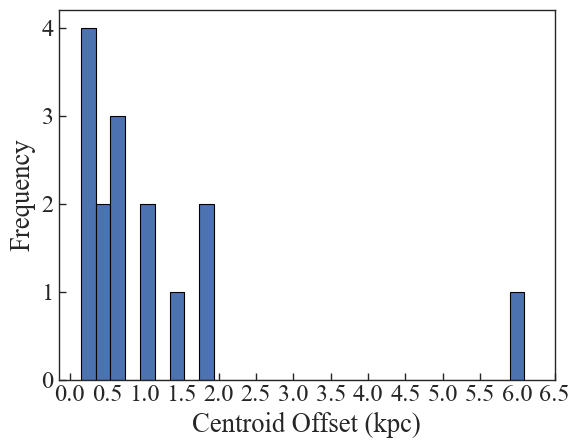

In [96]:
from scipy.stats import norm
# Calculating the mean centroid offset and 1 sigma of centroid offset
print("mean centroid offset: {0}".format(mean(center_diffs)))
print("median centroid offset: {0}".format(np.median(center_diffs)))
# 1 sigma of centroid offset
print("1 sigma centroid offset: {0}".format(np.std(center_diffs)))

# Calculating the mean, median and 68th percentile without the outlier
center_diffs_no_outlier = [x for x in center_diffs if x < 4]
print("mean centroid offset without outlier: {0}".format(mean(center_diffs_no_outlier)))
print("median centroid offset without outlier: {0}".format(np.median(center_diffs_no_outlier)))
# 1 sigma of centroid offset without the outlier
print("1 sigma centroid offset without outlier: {0}".format(np.std(center_diffs_no_outlier)))

plt.hist(center_diffs, bins=30, edgecolor='black')
plt.xticks(np.arange(0.0, 7, 0.5))
plt.xlabel('Centroid Offset (kpc)')
plt.ylabel('Frequency')
plt.show()

In [97]:
# Calculating mean & uncertainty of centroid offset
center_diffs_np = np.array(center_diffs)
sigma_center_diffs_np = np.array(sigma_center_diffs)
mean = np.sum(center_diffs_np/sigma_center_diffs_np**2)/np.sum(1/sigma_center_diffs_np**2)
sigma_mean = 1/np.sqrt(np.sum(1/sigma_center_diffs_np**2))
print("mean centroid offset: {0}".format(mean))
print("uncertainty of mean centroid offset: {0}".format(sigma_mean))

# Calculating mean & uncertainty of centroid offset without the outlier
center_diffs_no_outlier_np = np.array(center_diffs_no_outlier)
sigma_center_diffs_no_outlier_np = np.array([sigma_center_diffs[i] for i in range(len(center_diffs)) if center_diffs[i] < 4])
mean_no_outlier = np.sum(center_diffs_no_outlier_np/sigma_center_diffs_no_outlier_np**2)/np.sum(1/sigma_center_diffs_no_outlier_np**2)
sigma_mean_no_outlier = 1/np.sqrt(np.sum(1/sigma_center_diffs_no_outlier_np**2))
print("mean centroid offset without outlier: {0}".format(mean_no_outlier))
print("uncertainty of mean centroid offset without outlier: {0}".format(sigma_mean_no_outlier))

mean centroid offset: 0.4156494728385923
uncertainty of mean centroid offset: 0.010694888633720104
mean centroid offset without outlier: 0.4119468152944067
uncertainty of mean centroid offset without outlier: 0.010698375609854049


In [98]:
# Compute the intrinsic variance of centroid offset
# The average of the squared individual uncertainties
sigma_center_diffs_sq = [x**2 for x in sigma_center_diffs]
avg_sigma_center_diffs_sq = np.mean(sigma_center_diffs_sq)

# Compute sigma_intrinsic
sigma_intrinsic = np.sqrt(np.std(center_diffs)**2 - avg_sigma_center_diffs_sq)

print("avg_sigma_center_diffs: {0}".format(avg_sigma_center_diffs_sq))
print("sigma_observed: {0}".format(np.std(center_diffs)))
print("sigma_intrinsic: {0}".format(sigma_intrinsic))

avg_sigma_center_diffs: 0.018267250229843438
sigma_observed: 1.4307956815410283
sigma_intrinsic: 1.4243977787425157


## Scaling the Sigma values of different methods

1520.9942921981067


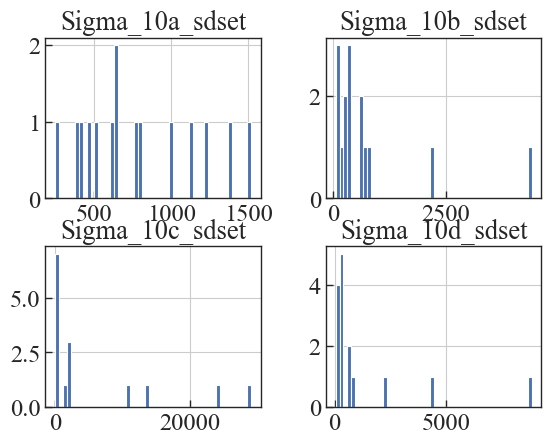

In [99]:
import pandas as pd
df_sigma = pd.DataFrame({'Sigma_10a_sdset': Sigma_10a_sdset, "Sigma_10b_sdset": Sigma_10b_sdset, "Sigma_10c_sdset": Sigma_10c_sdset, "Sigma_10d_sdset": Sigma_10d_sdset})
df_sigma.hist(bins=50)
print(df_sigma['Sigma_10a_sdset'].max())

Sigma_10a_sdset    247.731162
Sigma_10b_sdset     18.954674
Sigma_10c_sdset      4.000065
Sigma_10d_sdset      8.193540
dtype: float64


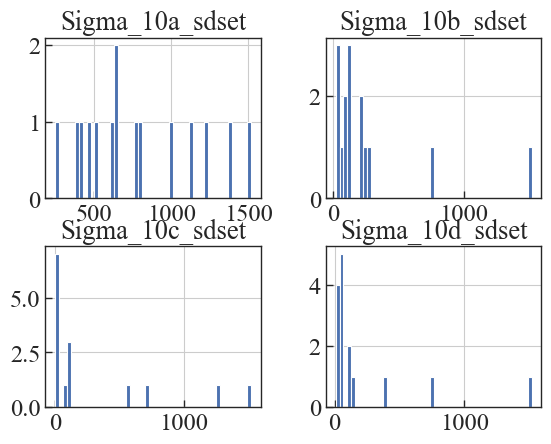

In [100]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(df_sigma)
sigma_scaled = scaler.transform(df_sigma)
sigma_scaled = sigma_scaled * (df_sigma['Sigma_10a_sdset'].max())
# print(sigma_scaled)
df_sigma_scaled = pd.DataFrame(sigma_scaled, columns=df_sigma.columns)
df_sigma_scaled.hist(bins=50) 

# lowest values of all scaled sigmas
print(df_sigma_scaled.min())

## Centroid offset vs. Sigma_10 from Method A

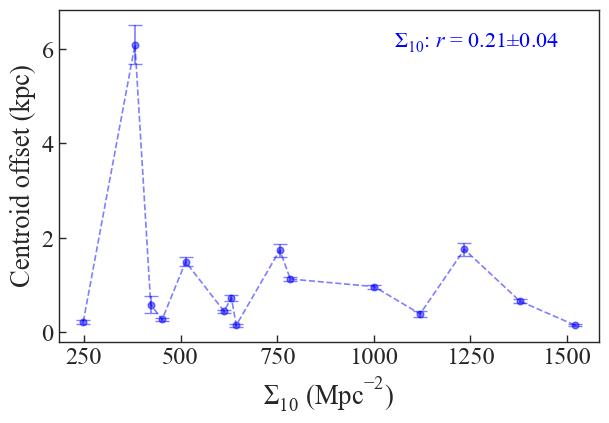

In [101]:
# fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_colwidth * 2))
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))
errbar_plot(
    Sigma_10a_sdset,
    center_diffs_10a,
    sigma_center_diffs_10a,
    ["S_10a", "centroid_offset1"],
    r_centroid_off_Sigma_10a,
    ax,
    "blue",
)

# fig.tight_layout()
plt.xlabel("$\Sigma_{10}$ (Mpc$^{-2})$")
plt.ylabel("Centroid offset (kpc)")
plt.show()
fig.savefig("../paper/figures/centroid_offset_vs_Sigma_10A.pdf", bbox_inches="tight")

## Centroid offset vs. (Sigma_10 from Method A to D).

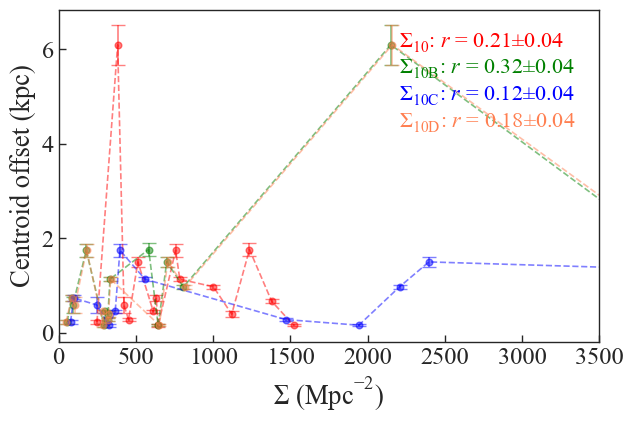

In [102]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10a_sdset,
    center_diffs_10a,
    sigma_center_diffs_10a,
    ["S_10a", "centroid_offset2"],
    r_centroid_off_Sigma_10a,
    ax,
    "red",
)
errbar_plot(
    Sigma_10b_sdset,
    center_diffs_10b,
    sigma_center_diffs_10b,
    ["S_10b", "centroid_offset2"],
    r_centroid_off_Sigma_10b,
    ax,
    "green",
)
errbar_plot(
    Sigma_10c_sdset,
    center_diffs_10c,
    sigma_center_diffs_10c,
    ["S_10c", "centroid_offset2"],
    r_centroid_off_Sigma_10c,
    ax,
    "blue",
)
errbar_plot(
    Sigma_10d_sdset,
    center_diffs_10d,
    sigma_center_diffs_10d,
    ["S_10d", "centroid_offset2"],
    r_centroid_off_Sigma_10d,
    ax,
    "coral",
)

ax.set_xlim(0, 3500)
# fig.tight_layout()
plt.xlabel("$\Sigma$ (Mpc$^{-2})$")
plt.ylabel("Centroid offset (kpc)")
plt.show()

## Centroid offset vs. (Sigma_10 from Method A to D) SCALED

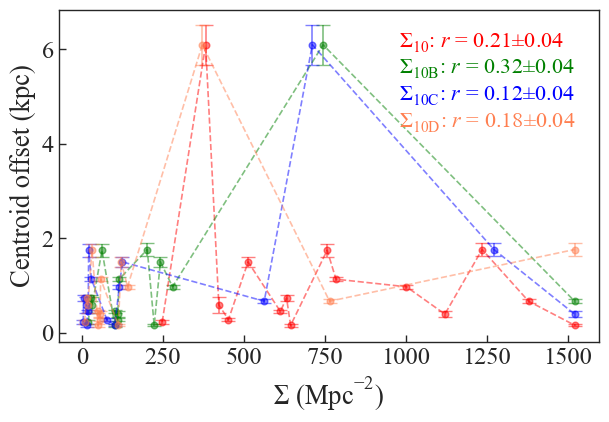

In [103]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))


errbar_plot(
    df_sigma_scaled['Sigma_10a_sdset'],
    center_diffs_10a,
    sigma_center_diffs_10a,
    ["S_10a", "centroid_offset2"],
    r_centroid_off_Sigma_10a,
    ax,
    "red",
)

errbar_plot(
    df_sigma_scaled['Sigma_10b_sdset'],
    center_diffs_10b,
    sigma_center_diffs_10b,
    ["S_10b", "centroid_offset2"],
    r_centroid_off_Sigma_10b,
    ax,
    "green",
)

errbar_plot(
    df_sigma_scaled['Sigma_10c_sdset'],
    center_diffs_10c,
    sigma_center_diffs_10c,
    ["S_10c", "centroid_offset2"],
    r_centroid_off_Sigma_10c,
    ax,
    "blue",
)

errbar_plot(
    df_sigma_scaled['Sigma_10d_sdset'],
    center_diffs_10d,
    sigma_center_diffs_10d,
    ["S_10d", "centroid_offset2"],
    r_centroid_off_Sigma_10d,
    ax,
    "coral",
)


# plt.legend(["$\Sigma_{10A}$", "$\Sigma_{10B}$", "$\Sigma_{10C}$", "$\Sigma_{10D}$"])
plt.xlabel("$\Sigma$ (Mpc$^{-2})$")
plt.ylabel("Centroid offset (kpc)")
fig.savefig("../paper/figures/centroid_offset_vs_Sigma_10AtoD.pdf", bbox_inches="tight")
plt.show()

## Centroid offset vs. Sigmas from Method A

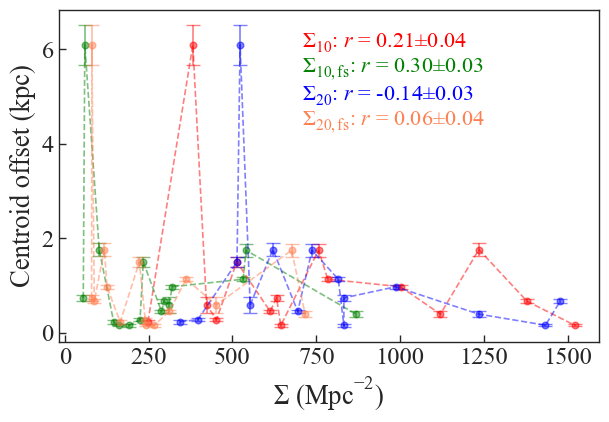

In [104]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10a_sdset,
    center_diffs_10a,
    sigma_center_diffs_10a,
    ["S_10a", "centroid_offset3"],
    r_centroid_off_Sigma_10a,
    ax,
    "red",
)
errbar_plot(
    Sigma_10afs_sdset,
    center_diffs_10afs,
    sigma_center_diffs_10afs,
    ["S_10afs", "centroid_offset3"],
    r_centroid_off_Sigma_10afs,
    ax,
    "green",
)
errbar_plot(
    Sigma_20a_sdset,
    center_diffs_20a,
    sigma_center_diffs_20a,
    ["S_20a", "centroid_offset3"],
    r_centroid_off_Sigma_20a,
    ax,
    "blue",
)
errbar_plot(
    Sigma_20afs_sdset,
    center_diffs_20afs,
    sigma_center_diffs_20afs,
    ["S_20afs", "centroid_offset3"],
    r_centroid_off_Sigma_20afs,
    ax,
    "coral",
)

# fig.tight_layout()
plt.xlabel("$\Sigma$ (Mpc$^{-2})$")
plt.ylabel("Centroid offset (kpc)")
plt.show()
fig.savefig("../paper/figures/centroid_offset_vs_Sigma_all.pdf", bbox_inches="tight")

# Position-angle offset vs. $\Sigma$ cases

## Position-angle offset vs. Sigma_10 from Method A

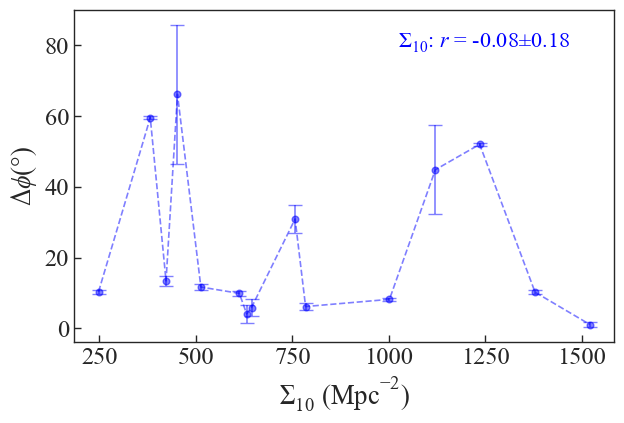

In [105]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

errbar_plot(
    Sigma_10a_sdset,
    dphis_10a,
    sigma_dphis_10a,
    ["S_10a", "position_angle_offset4"],
    r_dphi_Sigma_10a,
    ax,
    "blue",
)

# fig.tight_layout()
plt.xlabel("$\Sigma_{10}$ (Mpc$^{-2})$")
plt.ylabel("$\Delta \phi (\degree)$")
plt.show()
fig.savefig("../paper/figures/position_angle_offset_vs_Sigma_10A.pdf", bbox_inches="tight")

## Position-angle offset vs. (Sigma_10 from Method A to D)

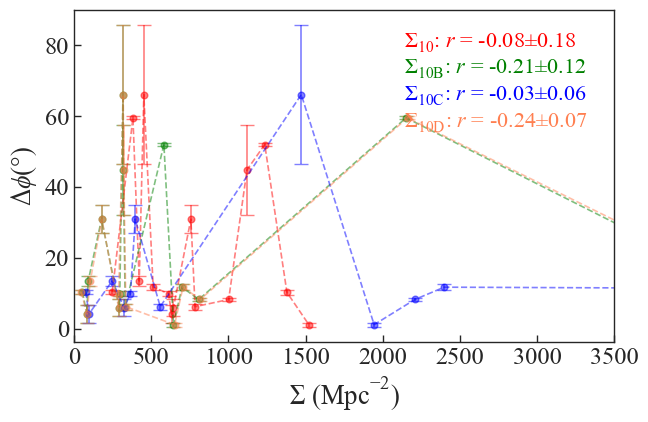

In [106]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)



errbar_plot(
    Sigma_10a_sdset,
    dphis_10a,
    sigma_dphis_10a,
    ["S_10a", "position_angle_offset5"],
    r_dphi_Sigma_10a,
    ax,
    "red",
)
errbar_plot(
    Sigma_10b_sdset,
    dphis_10b,
    sigma_dphis_10b,
    ["S_10b", "position_angle_offset5"],
    r_dphi_Sigma_10b,
    ax,
    "green",
)
errbar_plot(
    Sigma_10c_sdset,
    dphis_10c,
    sigma_dphis_10c,
    ["S_10c", "position_angle_offset5"],
    r_dphi_Sigma_10c,
    ax,
    "blue",
)
errbar_plot(
    Sigma_10d_sdset,
    dphis_10d,
    sigma_dphis_10d,
    ["S_10d", "position_angle_offset5"],
    r_dphi_Sigma_10d,
    ax,
    "coral",
)
ax.set_xlim(0, 3500)
# fig.tight_layout()
plt.xlabel("$\Sigma$ (Mpc$^{-2})$")
plt.ylabel("$\Delta \phi (\degree)$")
plt.show()


## Position-angle offset vs. (Sigma_10 from Method A to D) SCALED

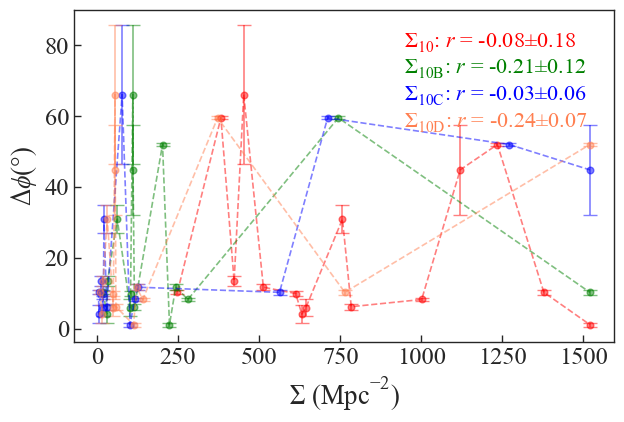

In [107]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

errbar_plot(
    df_sigma_scaled['Sigma_10a_sdset'],
    dphis_10a,
    sigma_dphis_10a,
    ["S_10a", "position_angle_offset5"],
    r_dphi_Sigma_10a,
    ax,
    "red",
)

errbar_plot(
    df_sigma_scaled['Sigma_10b_sdset'],
    dphis_10b,
    sigma_dphis_10b,
    ["S_10b", "position_angle_offset5"],
    r_dphi_Sigma_10b,
    ax,
    "green",
)

errbar_plot(
    df_sigma_scaled['Sigma_10c_sdset'],
    dphis_10c,
    sigma_dphis_10c,
    ["S_10c", "position_angle_offset5"],
    r_dphi_Sigma_10c,
    ax,
    "blue",
)

errbar_plot(
    df_sigma_scaled['Sigma_10d_sdset'],
    dphis_10d,
    sigma_dphis_10d,
    ["S_10d", "position_angle_offset5"],
    r_dphi_Sigma_10d,
    ax,
    "coral",
)

plt.xlabel("$\Sigma$ (Mpc$^{-2})$")
plt.ylabel("$\Delta \phi (\degree)$")
fig.savefig("../paper/figures/position_angle_offset_vs_Sigma_10AtoD.pdf", bbox_inches="tight")
plt.show()

## Position-angle offset vs. (Sigma_10 from Method A to D) Excluding high axis ratio

In [108]:
# Scale Sigma_10a, Sigma_10b, Sigma_10c, Sigma_10d only q_L < 0.9

df_sigma_ex_q_l = pd.DataFrame({'Sigma_10a_sdset': Sigma_10a_sdset_ex_q_l, "Sigma_10b_sdset": Sigma_10b_sdset_ex_q_l, "Sigma_10c_sdset": Sigma_10c_sdset_ex_q_l, "Sigma_10d_sdset": Sigma_10d_sdset_ex_q_l})

scaler = MaxAbsScaler()
scaler.fit(df_sigma_ex_q_l)
sigma_scaled_ex_q_l = scaler.transform(df_sigma_ex_q_l)
sigma_scaled_ex_q_l = sigma_scaled_ex_q_l * (df_sigma_ex_q_l['Sigma_10a_sdset'].max())
# print(sigma_scaled)
df_sigma_scaled_ex_q_l = pd.DataFrame(sigma_scaled_ex_q_l, columns=df_sigma_ex_q_l.columns)

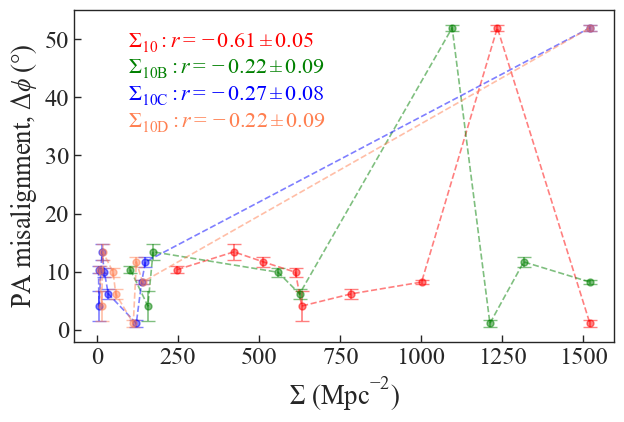

In [125]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)

# errbar_plot(
#     Sigma_10a_sdset_ex_q_l,
#     dphis_10a_ex_q_l,
#     sigma_dphis_10a_ex_q_l,
#     ["S_10a", "position_angle_offset6"],
#     r_dphi_Sigma_10a_ex_q_L,
#     ax,
#     "red",
# )

plt.errorbar(
    df_sigma_scaled_ex_q_l['Sigma_10a_sdset'],
    dphis_10a_ex_q_l,
    yerr=sigma_dphis_10a_ex_q_l,
    fmt="o--",
    color="red",
    label="S_10a",
    alpha=0.5,
    markersize=5,
    capsize=5,
)
plt.errorbar(
    df_sigma_scaled_ex_q_l['Sigma_10b_sdset'],
    dphis_10b_ex_q_l,
    yerr=sigma_dphis_10b_ex_q_l,
    fmt="o--",
    color="green",
    label="S_10b",
    alpha=0.5,
    markersize=5,
    capsize=5,
)

plt.errorbar(
    df_sigma_scaled_ex_q_l['Sigma_10c_sdset'],
    dphis_10c_ex_q_l,
    yerr=sigma_dphis_10c_ex_q_l,
    fmt="o--",
    color="blue",
    label="S_10c",
    alpha=0.5,
    markersize=5,
    capsize=5,
)

plt.errorbar(
    df_sigma_scaled_ex_q_l['Sigma_10d_sdset'],
    dphis_10d_ex_q_l,
    yerr=sigma_dphis_10d_ex_q_l,
    fmt="o--",
    color="coral",
    label="S_10d",
    alpha=0.5,
    markersize=5,
    capsize=5,
)

# case ["S_10b", "position_angle_offset5"]:
#             ax.text(
#                 0.61,
#                 0.82,
#                 r"$\Sigma_{10 \rm B}$: " + str,
#                 horizontalalignment="left",
#                 verticalalignment="center",
#                 transform=ax.transAxes,
#                 fontsize=16,
#                 color=c,

plt.text(0.1, 0.9, "$\Sigma_{{10}}: r = {0:.2f}\pm{1:.2f}$".format(r_dphi_Sigma_10a_ex_q_L[0], (r_dphi_Sigma_10a_ex_q_L[1] - r_dphi_Sigma_10a_ex_q_L[2])/2), horizontalalignment="left", verticalalignment="center", transform=ax.transAxes, fontsize=16, color="red")
plt.text(0.1, 0.82, "$\Sigma_{{10 \\rm B}}: r = {0:.2f}\pm{1:.2f}$".format(r_dphi_Sigma_10b_ex_q_L[0], (r_dphi_Sigma_10b_ex_q_L[1] - r_dphi_Sigma_10b_ex_q_L[2])/2), horizontalalignment="left", verticalalignment="center", transform=ax.transAxes, fontsize=16, color="green")
plt.text(0.1, 0.74, "$\Sigma_{{10 \\rm C}}: r = {0:.2f}\pm{1:.2f}$".format(r_dphi_Sigma_10c_ex_q_L[0], (r_dphi_Sigma_10c_ex_q_L[1] - r_dphi_Sigma_10c_ex_q_L[2])/2), horizontalalignment="left", verticalalignment="center", transform=ax.transAxes, fontsize=16, color="blue")
plt.text(0.1, 0.66, "$\Sigma_{{10 \\rm D}}: r = {0:.2f}\pm{1:.2f}$".format(r_dphi_Sigma_10d_ex_q_L[0], (r_dphi_Sigma_10d_ex_q_L[1] - r_dphi_Sigma_10d_ex_q_L[2])/2), horizontalalignment="left", verticalalignment="center", transform=ax.transAxes, fontsize=16, color="coral")
plt.xlabel("$\Sigma$ (Mpc$^{-2})$")
plt.ylabel("PA misalignment, $\Delta \phi\;(\degree)$")
plt.show()
fig.savefig("../paper/figures/position_angle_offset_vs_Sigma_10AtoD_ex_q_l.pdf", bbox_inches="tight")

## Position-angle offset vs. Sigmas from Method A


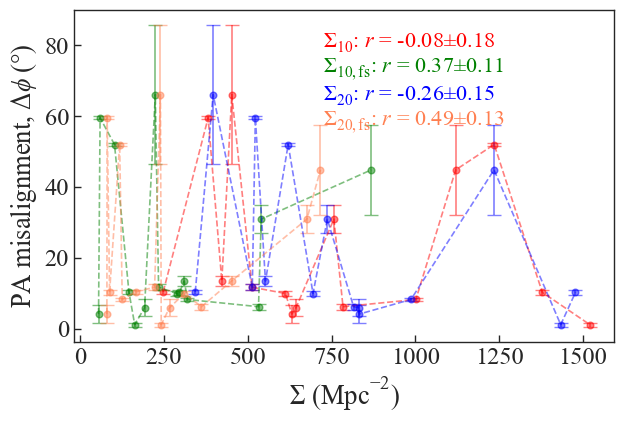

In [110]:
#### plot for all the four cases of position angle offset vs. Sigmas

fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10a_sdset,
    dphis_10a,
    sigma_dphis_10a,
    ["S_10a", "position_angle_offset6"],
    r_dphi_Sigma_10a,
    ax,
    "red",
)
errbar_plot(
    Sigma_10afs_sdset,
    dphis_10afs,
    sigma_dphis_10afs,
    ["S_10afs", "position_angle_offset6"],
    r_dphi_Sigma_10afs,
    ax,
    "green",
)
errbar_plot(
    Sigma_20a_sdset,
    dphis_20a,
    sigma_dphis_20a,
    ["S_20a", "position_angle_offset6"],
    r_dphi_Sigma_20a,
    ax,
    "blue",
)
errbar_plot(
    Sigma_20afs_sdset,
    dphis_20afs,
    sigma_dphis_20afs,
    ["S_20afs", "position_angle_offset6"],
    r_dphi_Sigma_20afs,
    ax,
    "coral",
)

# $\theta_{E}$, $\gamma_{shear}$ vs. $\Delta \phi$
# fig.tight_layout()
plt.xlabel("$\Sigma$ (Mpc$^{-2})$")
plt.ylabel("PA misalignment, $\Delta \phi\;(\degree)$")
plt.show()
fig.savefig("../paper/figures/position_angle_offset_vs_Sigma_all.pdf", bbox_inches="tight")

## Position-angle offset vs. Sigmas from Method A (Excluding high axis ratio)

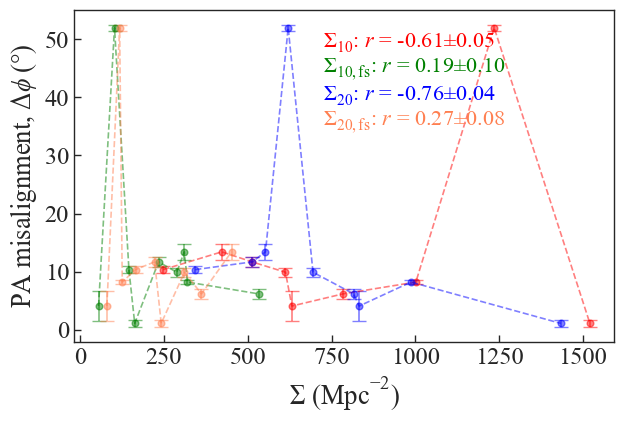

In [111]:
#### plot for all the four cases of position angle offset vs. Sigmas

fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10a_sdset_ex_q_l,
    dphis_10a_ex_q_l,
    sigma_dphis_10a_ex_q_l,
    ["S_10a", "position_angle_offset6"],
    r_dphi_Sigma_10a_ex_q_L,
    ax,
    "red",
)

errbar_plot(
    Sigma_10afs_sdset_ex_q_l,
    dphis_10afs_ex_q_l,
    sigma_dphis_10afs_ex_q_l,
    ["S_10afs", "position_angle_offset6"],
    r_dphi_Sigma_10afs_ex_q_L,
    ax,
    "green",
)
errbar_plot(
    Sigma_20a_sdset_ex_q_l,
    dphis_20a_ex_q_l,
    sigma_dphis_20a_ex_q_l,
    ["S_20a", "position_angle_offset6"],
    r_dphi_Sigma_20a_ex_q_L,
    ax,
    "blue",
)
errbar_plot(
    Sigma_20afs_sdset_ex_q_l,
    dphis_20afs_ex_q_l,
    sigma_dphis_20afs_ex_q_l,
    ["S_20afs", "position_angle_offset6"],
    r_dphi_Sigma_20afs_ex_q_L,
    ax,
    "coral",
)

# fig.tight_layout()

plt.xlabel("$\Sigma$ (Mpc$^{-2})$")
plt.ylabel("PA misalignment, $\Delta \phi\;(\degree)$")
plt.show()
fig.savefig("../paper/figures/position_angle_offset_vs_Sigma_all_ex_q_l.pdf", bbox_inches="tight")

## Function without connecting points

In [112]:
# Function for sampling and calculating the pearson correlation coefficients
# between two parameters


def errbar_plot_disconnected(dset1, dset2, error, param, r, ax, c):
    """
    Create scatter plot with error bars.

    :param dset1: list; dataset along the x-axis
    :param dset2: list; dataset along the y-axis
    :param error: error along the y-axis
    :param param: list of strings
    :param r: pearson-r
    :param ax: axis to plot on
    :param c: color
    :return: the plot
    """

    ax.errorbar(dset1, dset2, yerr=error, fmt="o", color=c, alpha=0.5, capsize=5)

    str = f"$r$ = {r[0]:.2f}$\pm${(r[1]-r[2])*.5:.2f}"

    match param:
        # For theta_E vs Sigma_10A and Gamma_shear vs Sigma_10A
        case ["S_10a", "theta_E_kpc"]:
            ax.text(
                0.52,
                0.9,
                r"$\theta_{E}$ vs. $\Sigma_{10}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
            # $\theta_{E}$, $\gamma_{\rm shear}$ vs. $\Delta \phi$

        case ["S_10a", "gamma_shear"]:
            ax.text(
                0.46,
                0.9,
                r"$\gamma_{\rm shear}$ vs. $\Sigma_{10}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )

        case ["S_10a", "gamma"]:
            ax.text(
                0.46,
                0.9,
                r"$\gamma$ vs. $\Sigma_{10}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
        
        case ["gamma_shear", "dphi"]:
            ax.text(
                0.46,
                0.9,
                r"$\gamma_{\rm shear}$ vs. $\Delta \phi$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )

    ax.tick_params(direction="in")

## Einstein Radius vs. Sigma_10 from Method A

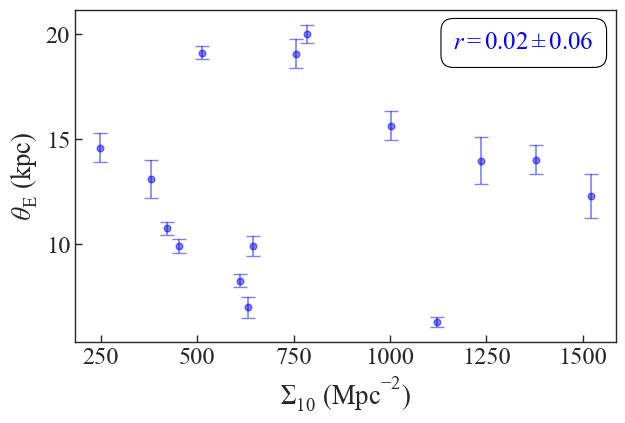

In [113]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# errbar_plot_disconnected(
#     Sigma_10a_sdset,
#     theta_E_m_10a,
#     theta_E_u_10a,
#     ["S_10a", "theta_E_kpc"],
#     r_theta_E_Sigma_10a,
#     ax,
#     "blue",
# )
plt.errorbar(Sigma_10a_sdset, theta_E_m_10a, yerr=theta_E_u_10a, fmt="o", color="blue", alpha=0.5, capsize=5)
plt.text(
    0.7,
    0.9,
    r"$r = {0:.2f} \pm {1:.2f}$".format(r_theta_E_Sigma_10a[0], (r_theta_E_Sigma_10a[1]-r_theta_E_Sigma_10a[2])*.5),
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=18,
    color="blue",
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

# fig.tight_layout()
plt.xlabel("$\Sigma_{10}$ (Mpc$^{-2})$")
plt.ylabel("$\\theta_{\\rm E}$ (kpc)")
plt.show()
fig.savefig("../paper/figures/einstein_radius_vs_Sigma_10A.pdf", bbox_inches="tight")

## Gamma Shear vs. Sigma_10 from Method A

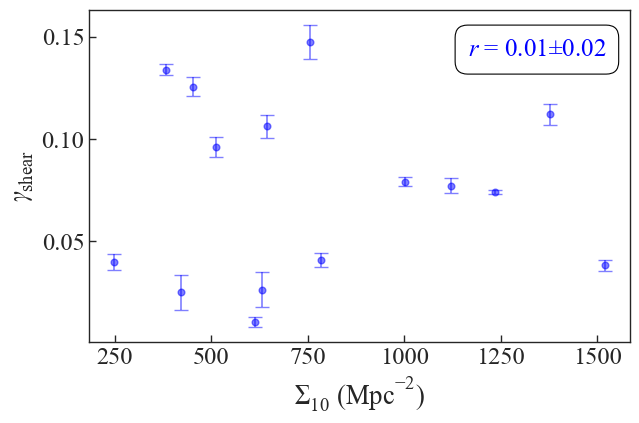

In [114]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# errbar_plot_disconnected(
#     Sigma_10a_sdset,
#     gamma_shear_m_10a,
#     gamma_shear_u_10a,
#     ["S_10a", "gamma_shear"],
#     r_gamma_shear_Sigma_10a,
#     ax,
#     "blue",
# )

plt.errorbar(Sigma_10a_sdset, gamma_shear_m_10a, yerr=gamma_shear_u_10a, fmt="o", color="blue", alpha=0.5, capsize=5)
plt.text(0.70, 0.88, r"$r$ = {0:.2f}$\pm${1:.2f}".format(r_gamma_shear_Sigma_10a[0], (r_gamma_shear_Sigma_10a[1]-r_gamma_shear_Sigma_10a[2])*.5), horizontalalignment="left", verticalalignment="center", transform=ax.transAxes, fontsize=18, color="blue", bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))

# fig.tight_layout()
plt.xlabel("$\Sigma_{10}$ (Mpc$^{-2})$")
plt.ylabel("$\gamma_{\\rm shear}$")
plt.show()
fig.savefig("../paper/figures/gamma_shear_vs_Sigma_10A.pdf", bbox_inches="tight")

## Gamma vs. Sigma_10 from Method A

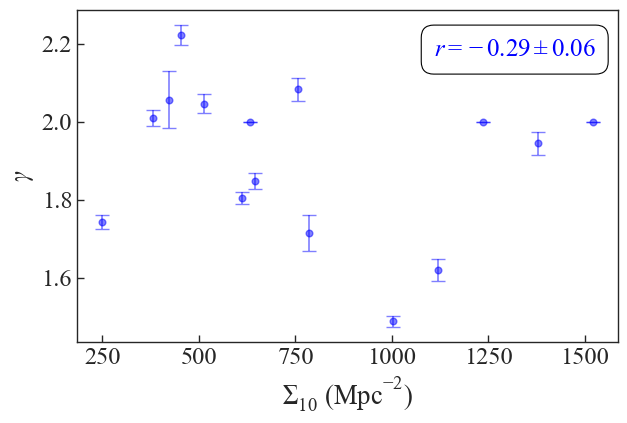

In [115]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# errbar_plot_disconnected(
#     Sigma_10a_sdset,
#     gamma_m_10a,
#     gamma_u_10a,
#     ["S_10a", "gamma"],
#     r_gamma_Sigma_10a,
#     ax,
#     "blue",
# )
plt.errorbar(Sigma_10a_sdset, gamma_m_10a, yerr=gamma_u_10a, fmt="o", color="blue", alpha=0.5, capsize=5)
plt.text(
    0.66,
    0.88,
    r"$r ={0:.2f}\pm{1:.2f}$".format(r_gamma_Sigma_10a[0], (r_gamma_Sigma_10a[1]-r_gamma_Sigma_10a[2])*.5),
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=18,
    color="blue",
    bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'),
)

plt.xlabel("$\Sigma_{10}$ (Mpc$^{-2})$")
plt.ylabel("$\gamma$")
plt.show()
fig.savefig("../paper/figures/gamma_vs_Sigma_10A.pdf", bbox_inches="tight")

## Gamma vs. Sigma_10 from Method A (Excluding fixed gamma)

[-0.4581778983136978, -0.4248249973355618, -0.4875939898755008]


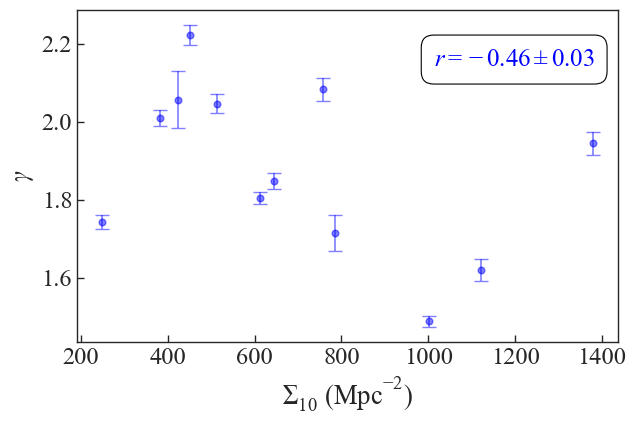

In [116]:
# gamma cases excluding gamma fixed
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

plt.errorbar(Sigma_10a_sdset_ex_gamma, gamma_m_10a_ex_q_l, yerr=gamma_u_10a_ex_q_l, fmt="o", color="blue", alpha=0.5, capsize=5)
# plt.legend(["$\gamma$ vs. $\Sigma_{{10A}}$: $r$ = {0:.2f}".format()], shadow=True, framealpha=0.9)
print(r_gamma_Sigma_10a_ex_fixed_gamma)
plt.text(0.66, 0.85, "$r = {0:.2f} \pm {1:.2f}$".format(r_gamma_Sigma_10a_ex_fixed_gamma[0], (r_gamma_Sigma_10a_ex_fixed_gamma[1]-r_gamma_Sigma_10a_ex_fixed_gamma[2])*.5), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=18, color='blue', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


plt.xlabel("$\Sigma_{10}$ (Mpc$^{-2})$")
plt.ylabel("$\gamma$")
plt.show()
fig.savefig("../paper/figures/gamma_vs_Sigma_10A_ex_fixed_gamma.pdf", bbox_inches="tight")

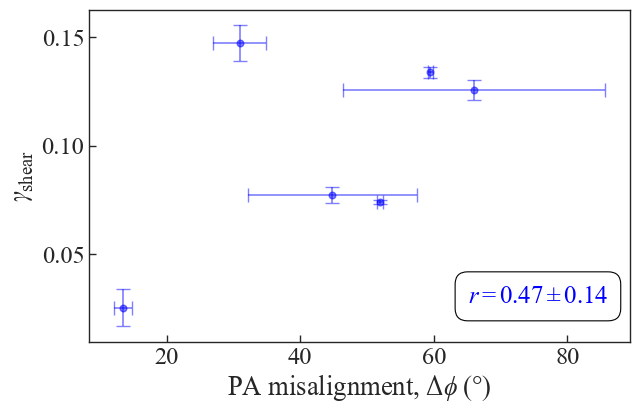

In [117]:
# PA offset vs gamma shear
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# Add error bars for dphi
plt.errorbar(dphis_ex_pa_10a, gamma_shear_m_ex_pa_10a, xerr=sigma_dphis_ex_pa_10a, yerr=gamma_shear_u_ex_pa_10a, fmt="o", color="blue", alpha=0.5, capsize=5)
# plt.legend(["$r$ = {0:.2f}".format(r_dphi_gamma_shear_ex_pa[0])], shadow=True, framealpha=0.9)
plt.text(0.7, 0.1, "$r = {0:.2f} \pm {1:.2f}$".format(r_dphi_gamma_shear_ex_pa[0], (r_dphi_gamma_shear_ex_pa[1]-r_dphi_gamma_shear_ex_pa[2])*0.5), horizontalalignment="left", verticalalignment="bottom", transform=ax.transAxes, fontsize=18, color="blue", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# fig.tight_layout()
plt.xlabel("PA misalignment, $\Delta \phi\;(\degree)$")
plt.ylabel("$\gamma_{\\rm shear}}$")

plt.show()
fig.savefig("../paper/figures/gamma_shear_vs_pa_offset.pdf", bbox_inches="tight")